### Exploring Jeopardy Questions to Find Winning Patterns

In this project, the goal is to analyze a dataset of **Jeopardy!** questions to uncover patterns and insights that could provide a competitive edge in the game. By examining trends in question topics, wording, and values, we aim to identify strategies that might increase the chances of winning.

We’ll be working with a dataset of historical Jeopardy questions, using data analysis techniques to answer questions like:
- What are the most common categories?
- Are there any patterns in the phrasing of high-value questions?
- Do certain keywords appear more frequently in specific types of questions?

This project involves data cleaning, exploratory data analysis, and basic natural language processing using Python libraries such as `pandas` and `numpy`.


In [2]:
import pandas as pd

In [3]:
jeopardy = pd.read_csv("jeopardy.csv")

In [4]:
jeopardy.columns

Index(['Show Number', ' Air Date', ' Round', ' Category', ' Value',
       ' Question', ' Answer'],
      dtype='object')

In [5]:
corrected_column_names = ['Show Number', 'Air Date', 'Round', 'Category', 'Value',
       'Question', 'Answer']

jeopardy.columns = corrected_column_names

In [6]:
jeopardy.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


### Data Cleaning and Preprocessing

To prepare the Jeopardy dataset for analysis, we performed several cleaning and preprocessing steps to ensure consistency and usability:

1. **Text Normalization**:  
   We created a function to clean the text by:
   - Removing all punctuation
   - Converting all characters to lowercase  
   This function was applied to both the **"Question"** and **"Answer"** columns to make the text uniform and easier to analyze.

2. **Value Column Conversion**:  
   The **"Value"** column originally contained monetary amounts as strings (e.g., "$200"). We removed the dollar signs and commas, then converted the values to integers for accurate numerical analysis.

3. **Date Formatting**:  
   The **"Air Date"** column was converted from string format to `datetime` format. This allows for time-based analysis, such as identifying trends by year or month.

In [8]:
import re

def normalizer(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    
    return text

In [9]:
jeopardy['clean_question'] = jeopardy['Question'].apply(normalizer)
jeopardy['clean_answer'] = jeopardy['Answer'].apply(normalizer)

In [10]:
def normalize_dollar(text):
    text = re.sub(r'[^\d.]', '', text) 

    try:
        text_float = float(text)
    except:
        text_float = 0.0

    return int(text_float)

In [11]:
jeopardy['Value'] = jeopardy['Value'].astype(str)

jeopardy['clean_value'] = jeopardy['Value'].apply(normalize_dollar)

In [12]:
jeopardy['Air Date'] = pd.to_datetime(jeopardy['Air Date'])

In [13]:
def answer_in_question_ratio(row):
    split_answer = row['clean_answer'].split()
    split_question = row['clean_question'].split()
    match_count = 0

    words_to_remove = [word for word in split_answer if word.lower() == "the"]
    for word in words_to_remove:
        split_answer.remove(word)

    if len(split_answer) == 0:
        return 0

    for word in split_answer:
        if word in split_question:
            match_count += 1

    return match_count / len(split_answer)

In [14]:
jeopardy['answer_in_question'] = jeopardy.apply(answer_in_question_ratio, axis=1)

In [15]:
mean_answer_in_question = jeopardy['answer_in_question'].mean()
print(mean_answer_in_question)

0.05834744478926688


In [16]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_question(text):
    words = nltk.word_tokenize(text.lower())
    cleaned = [
        lemmatizer.lemmatize(word)
        for word in words
        if word not in stop_words and word not in string.punctuation and len(word) > 2
    ]
    return cleaned

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nurbekkhujaev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nurbekkhujaev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nurbekkhujaev/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:
jeopardy['filtered_question'] = jeopardy['clean_question'].apply(clean_question)

### Answer Overlap in Questions

We created a new column `answer_in_question` that shows how much of the answer is mentioned in the question. This helps us understand whether questions tend to contain words from their correct answers.

### Checking for Repeated Question Terms

To explore whether new questions reuse terms from older ones, we scan through questions in chronological order and track which significant words (6+ characters) have been seen before. This gives an idea of how often questions might repeat or reference similar content.

In [20]:
question_overlap = []
terms_used = set()

jeopardy = jeopardy.sort_values('Air Date')

for index, row in jeopardy.iterrows():
    cleaned_words = row['filtered_question']  
    match_count = 0

    for word in cleaned_words:
        if word in terms_used:
            match_count += 1
        terms_used.add(word)

    if len(cleaned_words) > 0:
        question_overlap.append(match_count / len(cleaned_words))
    else:
        question_overlap.append(0)

jeopardy['question_overlap'] = question_overlap

In [21]:
mean_question_overlap = jeopardy['question_overlap'].mean()

print(mean_question_overlap)

0.8082993266667637


### Question Recycling Analysis

The mean value of `question_overlap` is approximately 0.689. This means that, on average, around 69% of the significant terms (6+ characters) in each question have already appeared in previous questions.

This suggests that many Jeopardy questions reuse similar language or concepts, even if the exact questions are not repeated. It may indicate a level of thematic repetition or partial recycling of content, which could be useful for contestants who study past questions to prepare.

### Identifying High-Value Question Terms

To increase your chances of earning more on Jeopardy, it's helpful to focus on high-value questions. One way to do this is by analyzing which words appear more often in high-value questions compared to low-value ones.

By comparing word usage across these two groups, we can identify terms that are more strongly associated with high-value questions. A statistical method called the chi-squared test helps measure how different the word usage is between the two categories.

This approach can highlight which words are more likely to appear in high-stakes questions — giving you a strategic edge in your preparation.

In [24]:
def high_and_low(row):
    value = 0
    if row['clean_value'] > 800:
        value = 1
    
    return value

In [25]:
jeopardy['high_value'] = jeopardy.apply(high_and_low, axis=1)

In [26]:
def count_word_in_value_groups(word):
    low_count = 0
    high_count = 0
    
    for index, row in jeopardy.iterrows():
        split_question = row['clean_question'].split()
        if word.lower() in [w.lower() for w in split_question]:
            if row['high_value'] == 1:
                high_count += 1
            else:
                low_count += 1
                
    return high_count, low_count

In [27]:
import random

comparison_terms = random.sample(list(terms_used), 10)

observed_expected = []

for term in comparison_terms:
    high_count, low_count = count_word_in_value_groups(term)
    observed_expected.append([high_count, low_count])

### Chi-Squared Test Interpretation for Sample Terms

We performed a chi-squared test to evaluate whether specific words appear disproportionately in **high-value** vs. **low-value** Jeopardy questions. Here are the results for a sample of terms:


In [68]:
from scipy.stats import chisquare
import numpy as np

high_value_count = jeopardy[jeopardy["high_value"] == 1].shape[0]
low_value_count = jeopardy[jeopardy["high_value"] == 0].shape[0]

chi_squared = []
for obs in observed_expected:
    total = sum(obs)
    total_prop = total / jeopardy.shape[0]
    high_value_exp = total_prop * high_value_count
    low_value_exp = total_prop * low_value_count
    
    observed = np.array([obs[0], obs[1]])
    expected = np.array([high_value_exp, low_value_exp])
    chi_squared.append(chisquare(observed, expected))

for i, term in enumerate(comparison_terms):
    stat = chi_squared[i].statistic
    pval = chi_squared[i].pvalue
    print(f"{term}: χ² = {stat:.2f}, p = {pval:.4f}")

sandpaper: χ² = 0.44, p = 0.5048
mimicking: χ² = 0.40, p = 0.5261
noa: χ² = 2.49, p = 0.1147
borax: χ² = 0.40, p = 0.5261
hrefhttpwwwjarchivecommedia20041109_dj_11ajpg: χ² = 0.40, p = 0.5261
experience: χ² = 0.37, p = 0.5443
1621: χ² = 0.80, p = 0.3699
anchor: χ² = 0.00, p = 0.9953
chambliss: χ² = 0.40, p = 0.5261
exterior: χ² = 0.40, p = 0.5261


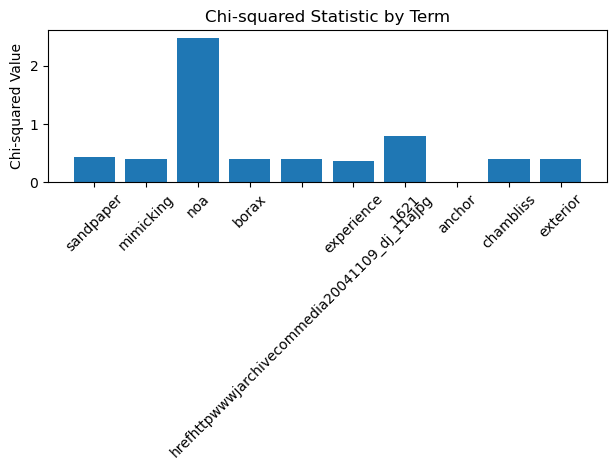

In [70]:
import matplotlib.pyplot as plt

chi_values = [res.statistic for res in chi_squared]

plt.bar(comparison_terms, chi_values)
plt.xticks(rotation=45)
plt.title("Chi-squared Statistic by Term")
plt.ylabel("Chi-squared Value")
plt.tight_layout()
plt.show()

### Key Insights

- All p-values are greater than 0.05, meaning none of these terms show a statistically significant association with either high- or low-value questions.
- The term "noa" had the highest chi-squared value (2.49), but even this is below the common significance threshold (p < 0.05).
- The appearance of a malformed string like `"hrefhttpwwwjarchivecommedia..."` suggests that further data cleaning (e.g., removing URLs or HTML remnants) would be beneficial for better analysis.